In [2]:
import sys
sys.path.append("../../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from example_pendulum import get_pendulum_data, pendulum_to_movie
import os
import pickle
from autoencoder import FullNetwork as FullNetwork
import torch
from training import prepare_data
from sindy_utils import sindy_simulate
from sindy_utils import sindy_simulate_order2

data_path = os.getcwd() + '\\'
save_name = 'pendulum_2024_05_28_17_52_35_042480'
# save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
# dataframe = pd.read_pickle('model1_params.pkl')
# print(dataframe)
# print(dataframe['coefficient_mask'])

def convert_to_cpu_numpy(obj):
    """
    Recursively convert torch.Tensor objects to numpy arrays,
    handling dictionaries and lists.
    
    Parameters:
    obj (any): The object to convert, which could be a tensor, list, or dictionary.

    Returns:
    any: The converted object with tensors replaced by numpy arrays.
    """
    if isinstance(obj, torch.Tensor):
        return obj.cpu().numpy()  #
    elif isinstance(obj, dict):
        #
        return {k: convert_to_cpu_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        # 
        return [convert_to_cpu_numpy(v) for v in obj]
    else:
        return obj  
# dataframe['coefficient_mask'] = dataframe['coefficient_mask'].apply(convert_to_cpu_numpy)
# dataframe['sindy_coefficients'] = dataframe['sindy_coefficients'].apply(convert_to_cpu_numpy)


# Xi_plot = np.array(dataframe['coefficient_mask']*dataframe['sindy_coefficients'])[0]
# sindy_coefficients = np.array(dataframe['sindy_coefficients'])[0]
# coefficient_mask = np.array(dataframe['coefficient_mask'])[0]
# print(dataframe['coefficient_mask'][0])
   

In [3]:
params['device'] = 'cuda:0'
autoencoder_network = FullNetwork(params).to(params['device'])
path = data_path + 'pendulum_2024_05_28_17_52_35_042480.pth'
state_dict = torch.load(path)
# print state_dict values
# for key in state_dict:
#     print(key)
#     print(state_dict[key])
autoencoder_network.load_state_dict(state_dict)

Xi_plot = np.array(state_dict['coefficient_mask']*state_dict['sindy_coefficients'])
print(Xi_plot)
sindy_coefficients = np.array(state_dict['sindy_coefficients'])
print(sindy_coefficients)
coefficient_mask = np.array(state_dict['coefficient_mask'])
print(coefficient_mask)

[[ 1.26862171e-04]
 [-8.95674229e-01]
 [ 3.96408032e-05]
 [ 6.13733642e-02]
 [-7.11527173e-06]
 [-7.25442544e-02]
 [ 1.01257354e-01]
 [-2.15294218e-04]
 [-6.18480044e-06]
 [ 8.85150002e-05]
 [-1.67947641e-04]
 [ 4.30316053e-04]]
[[ 1.26862171e-04]
 [-8.95674229e-01]
 [ 3.96408032e-05]
 [ 6.13733642e-02]
 [-7.11527173e-06]
 [-7.25442544e-02]
 [ 1.01257354e-01]
 [-2.15294218e-04]
 [-6.18480044e-06]
 [ 8.85150002e-05]
 [-1.67947641e-04]
 [ 4.30316053e-04]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


SIngle plot

In [4]:
t = np.arange(0, 20, .02)
z0s = np.pi/np.array([1.5,2,3,4,8,16])
dz0s = .5*np.ones(z0s.shape)

f  = lambda z, t : [z[1], -np.sin(z[0])]
n_ics = z0s.size

z = np.zeros((n_ics,t.size,2))
dz = np.zeros(z.shape)
for i in range(n_ics):
    z[i] = odeint(f, [z0s[i],dz0s[i]], t)
    dz[i] = np.array([f(z[i,j], t[j]) for j in range(len(t))])
    
x,dx,ddx = pendulum_to_movie(z,dz)

In [5]:
test_data = {}
test_data['x'] = x.reshape((-1,params['input_dim']))
test_data['dx'] = dx.reshape((-1,params['input_dim']))
test_data['ddx'] = ddx.reshape((-1,params['input_dim']))
test_data['z'] = z[:,:,0].reshape((-1,params['latent_dim']))
test_data['dz'] = z[:,:,1].reshape((-1,params['latent_dim']))
test_data['ddz'] = dz[:,:,1].reshape((-1,params['latent_dim']))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = autoencoder_network
model.load_state_dict(state_dict)
model.eval()  


test_dictionary = prepare_data(test_data,params,device)


test_dictionary_ = {}
# for key in test_dictionary:
#     if key == "x" or key =="dx" or key == "ddx":
#         test_dictionary_[key] = torch.tensor(test_dictionary[key]).to(device)
for key in test_dictionary:
    if key == "x" or key =="dx" or key == "ddx":
        test_dictionary_[key] = torch.tensor(test_dictionary[key], requires_grad=True).to(device)

with torch.no_grad():  
    torch_results = model(**test_dictionary_)

test_set_results = []
for i, output in enumerate(torch_results):
    test_set_results.append(output.cpu().detach().numpy())

#  z, x_decode, dz, dx_decode, ddz, x, dx,self.sindy_coefficients, ddx_decode, sindy_predict, ddx

ddz torch.Size([6000, 2601]) torch.Size([128, 2601])
sigmoid_derivative shape: torch.Size([6000, 128])
ddz_temp shape: torch.Size([6000, 128])
dz_temp shape: torch.Size([6000, 128])
term1 shape: torch.Size([6000, 128])
term2 shape: torch.Size([6000, 128])
ddz torch.Size([6000, 128]) torch.Size([64, 128])
sigmoid_derivative shape: torch.Size([6000, 64])
ddz_temp shape: torch.Size([6000, 64])
dz_temp shape: torch.Size([6000, 64])
term1 shape: torch.Size([6000, 64])
term2 shape: torch.Size([6000, 64])
ddz torch.Size([6000, 64]) torch.Size([32, 64])
sigmoid_derivative shape: torch.Size([6000, 32])
ddz_temp shape: torch.Size([6000, 32])
dz_temp shape: torch.Size([6000, 32])
term1 shape: torch.Size([6000, 32])
term2 shape: torch.Size([6000, 32])
theta torch.Size([6000, 12])
torch.Size([12, 1]) torch.Size([12, 1])
z torch.Size([6000, 1])
ddz torch.Size([6000, 1]) torch.Size([32, 1])
sigmoid_derivative shape: torch.Size([6000, 32])
ddz_temp shape: torch.Size([6000, 32])
dz_temp shape: torch.Si

C:\Users\zhaox\AppData\Local\Temp\ipykernel_23600\4246565283.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dictionary_[key] = torch.tensor(test_dictionary[key], requires_grad=True).to(device)


In [7]:
true_coefficients = np.zeros(test_set_results[7].shape)
true_coefficients[-2] = -1.

z_sim = np.zeros((n_ics, t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate_order2(test_set_results[0][i*t.size], test_set_results[2][i*t.size], t,
                                     params['coefficient_mask']*test_set_results[7],
                                     params['poly_order'], params['include_sine'])
    pendulum_sim[i] = sindy_simulate_order2(test_data['z'][i*t.size], test_data['dz'][i*t.size], t,
                                            true_coefficients,
                                            params['poly_order'], params['include_sine'])

([], [])

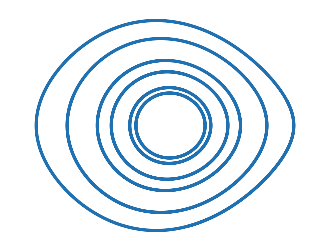

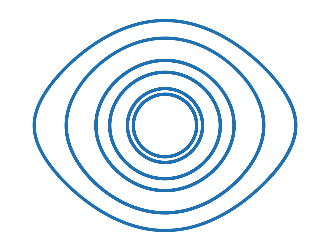

In [8]:
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,:,0].T, z_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(pendulum_sim[:,:,0].T, pendulum_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

C:\Users\zhaox\AppData\Local\Temp\ipykernel_23600\2145945778.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results[0][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)


(-49.95, 1048.95, -1.9330631494522095, 1.7740222215652466)

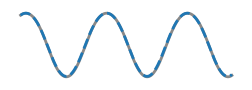

In [9]:

ic_idx = 1

plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results[0][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')